In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import warnings
import matplotlib.pyplot as plt

%matplotlib inline
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.decomposition import PCA 
from scipy.sparse import coo_matrix

> **Load data**

In [306]:
col_names = ['Age', 'Sex', 'CP', 'Trestbps', 'Chol', 'FBS', 'Restecg', 'Thalach',
             'Exang', 'Oldpeak', 'Slope', 'CA', 'Thal', 'Num']
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data',
                  names = col_names)

> abbreviation of each column
    
    CP = Chest Pain ( 1 - typical angina, 2 - atypical angina, 3 - non-anginal pain, 4 - asymptomatic )
    Trestbps = Resting Blood Pressure
    Chol = Serum Cholestoral
    FBS = Fasting Blood Sugar ( 0 - false, 1 - true)
    Restecg = Resting Electrocardiographic Results ( 0 - normal, 1 - little abnormal, 2 - sympton )
    Thalach = Maximum Heart Rate
    Exang = Exercise Induced Angina ( 0 - no, 1 - yes )
    Oldpeak = ST Depression Induced by Exercise
    Slope = Slope of the Peak Exercise ST Segment ( 1 - upslople, 2 - flat, 3 - downslope )
    CA = Number of Major Vessels ( 0 - 3 )
    Thal = ( 3 - normal, 6 - fixed defect, 7 - reversable defect )
    *Num = Diagnosis of Heart Disease ( Value 0 - < 50% diameter narrowing; Value 1 - > 50% diameter narrowing )

> **Learn about the dataset**

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
Age         303 non-null float64
Sex         303 non-null float64
CP          303 non-null float64
Trestbps    303 non-null float64
Chol        303 non-null float64
FBS         303 non-null float64
Restecg     303 non-null float64
Thalach     303 non-null float64
Exang       303 non-null float64
Oldpeak     303 non-null float64
Slope       303 non-null float64
CA          303 non-null object
Thal        303 non-null object
Num         303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


In [308]:
df.describe()

,Age,Sex,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,Num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [309]:
df.describe(include = [np.object])

,CA,Thal
count,303,303
unique,5,4
top,0.0,3.0
freq,176,166


In [310]:
df.groupby('CA')['CA'].count()

CA
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: CA, dtype: int64

In [311]:
df['CA'][df['CA'] == 0.0].count()

0

In [312]:
df.loc[df.CA == '?']

,Age,Sex,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Num
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


In [313]:
df.groupby('Thal')['Thal'].count()

Thal
3.0    166
6.0     18
7.0    117
?        2
Name: Thal, dtype: int64

In [314]:
df.loc[df.Thal == '?']

,Age,Sex,CP,Trestbps,Chol,FBS,Restecg,Thalach,Exang,Oldpeak,Slope,CA,Thal,Num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2


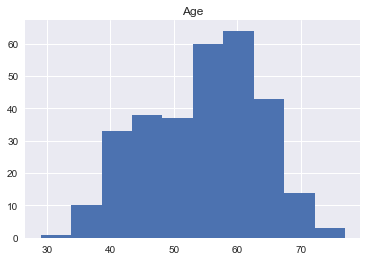

In [315]:
# display a Histogram for the age of the patiences
df.hist(column = 'Age')
plt.show()

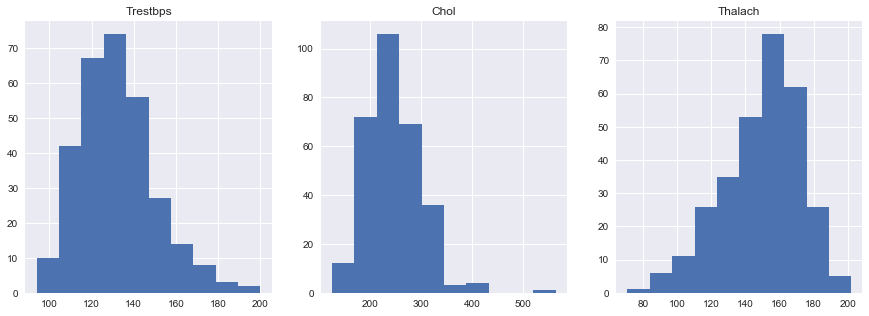

In [316]:
# plot Trestbps, Chol, Thalach to identify outliers
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.hist(df.Trestbps)
plt.title('Trestbps')

plt.subplot(1, 3, 2)
plt.hist(df.Chol)
plt.title('Chol')

plt.subplot(1, 3, 3)
plt.hist(df.Thalach)
plt.title('Thalach')

plt.savefig('Outliers.png')
plt.show()

* it seems that chol has an outlier


Counts of each Value
0    164
1     55
2     36
3     35
4     13
Name: Num, dtype: int64




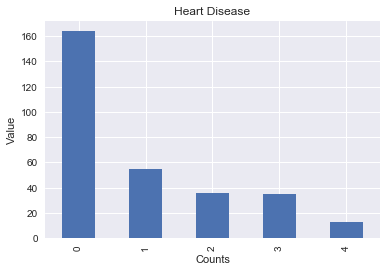

In [317]:
# display the counts of targeted variable
count_num = pd.value_counts(df['Num'], sort = True)
count_num.plot(kind = 'bar')

print('\nCounts of each Value')
print(count_num)
print('\n')

plt.title('Heart Disease')
plt.xlabel('Counts')
plt.ylabel('Value')

plt.savefig('Target.png')
plt.show()

* Value 0 - less than 50% diameter narrowing, safe
* Value 1~4 - greater than 50% diameter narrowing, higher value is more severe
    
    => want to turn this into a binary variable

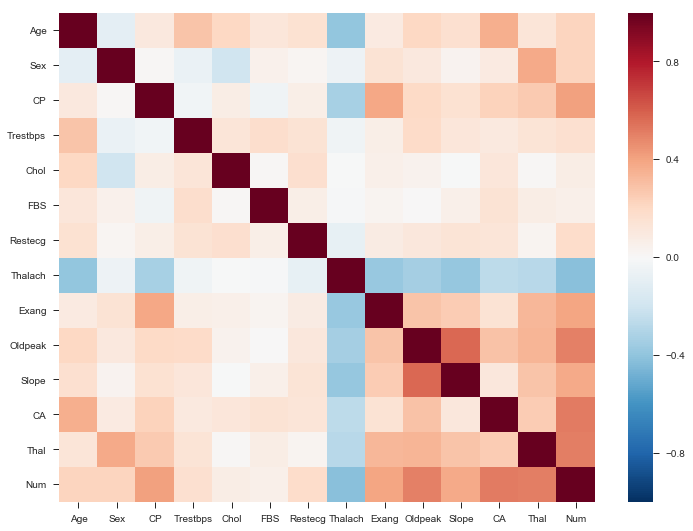

In [90]:
# ** run after cleaning the data **
# display the correlation between targeted variable and features
plt.subplots(figsize=(12, 9))
df_corr = df.corr()
sns.heatmap(df_corr)
plt.show()

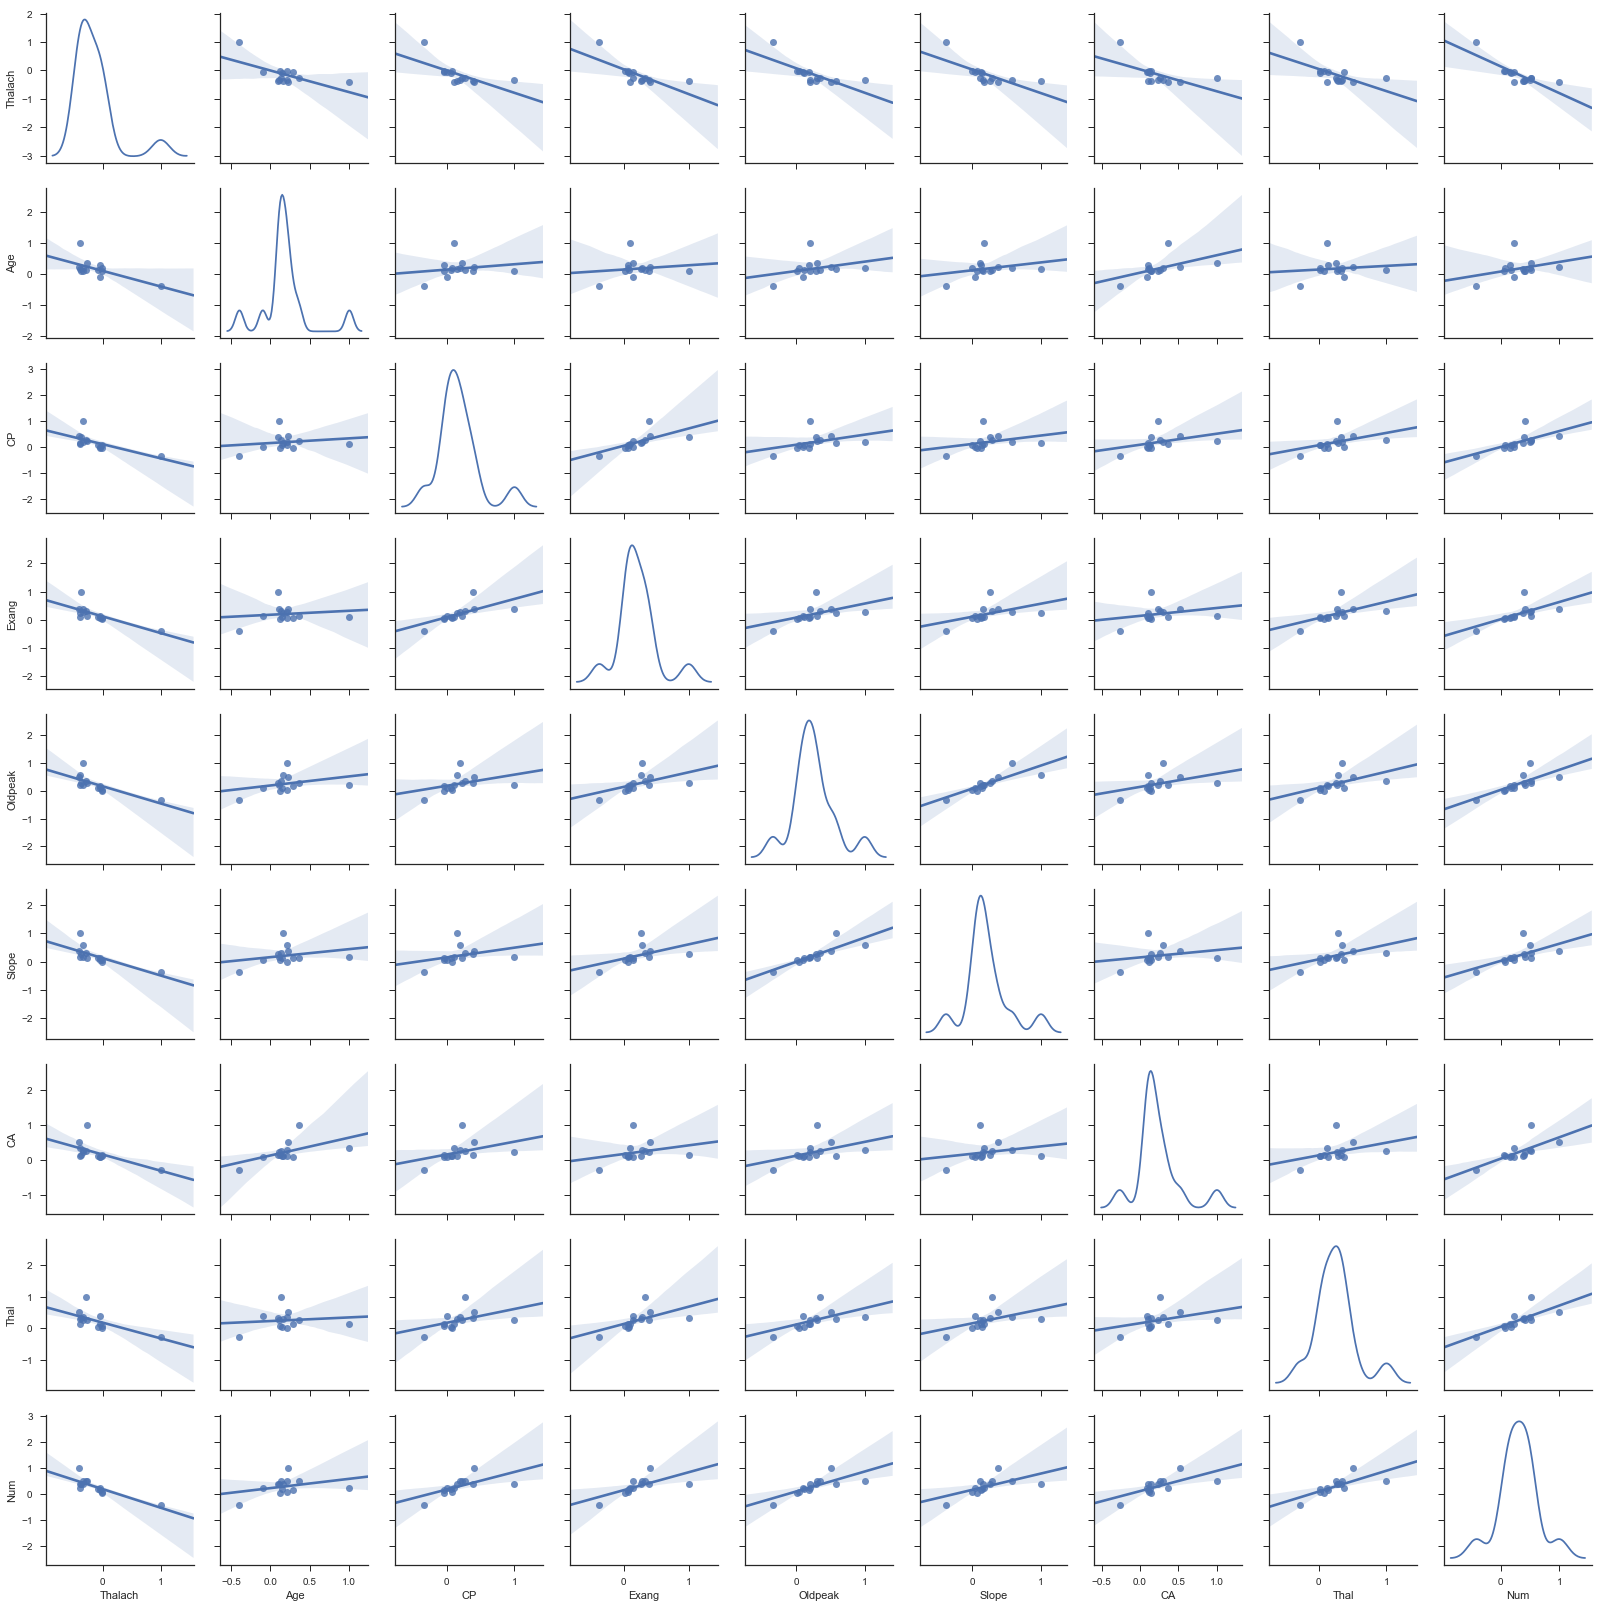

In [91]:
sns.set(style="ticks")

# graph the relationship between 'thalach' and the rest of the variables (negative correlation)
g = sns.pairplot(df_corr, vars = ['Thalach', 'Age', 'CP', 'Exang', 'Oldpeak', 'Slope', 'CA', 'Thal', 'Num'],
                 diag_kind = 'kde',
                 kind = 'reg')

> **Clean the data and Prepare them for modeling**

In [318]:
# list the index with '?' as values
ca_index = df.loc[df.CA == '?'].index
thal_index = df.loc[df.Thal == '?'].index
ind = ca_index.append(thal_index)

# replace '?' with 'NaN'
for i in ind:
    df.iloc[i:] = df.iloc[i:].replace('?', '')

# change 'CA' and 'Thal' to float type for imputation    
df['CA'] = pd.to_numeric(df['CA']).astype(float)
df['Thal'] = pd.to_numeric(df['Thal']).astype(float)    #change this back to obj for binarization

In [319]:
# want to impute the missing data 
col_names = df.columns    # Rename the columns after imputation
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent')
new_df = imp.fit_transform(df)
new_df = pd.DataFrame(new_df, columns = col_names)

In [320]:
# want to change targeted variable to binary ( 0 - safe, 1 - not safe)
new_df['Num'] = new_df['Num'].apply(lambda x: 1 if x >= 1 else 0)

# want to binarize CP, Restecg, Slope, Thal
new_df['CP'] = pd.to_numeric(new_df['CP']).astype(object)
new_df['Restecg'] = pd.to_numeric(new_df['Restecg']).astype(object)
new_df['Slope'] = pd.to_numeric(new_df['Slope']).astype(object)
new_df['CA'] = pd.to_numeric(new_df['CA']).astype(object)
new_df['Thal'] = pd.to_numeric(new_df['Thal']).astype(object)

# binarize
new_df = pd.get_dummies(new_df)

In [321]:
new_df.head()

,Age,Sex,Trestbps,Chol,FBS,Thalach,Exang,Oldpeak,Num,CP_1.0,...,Slope_1.0,Slope_2.0,Slope_3.0,CA_0.0,CA_1.0,CA_2.0,CA_3.0,Thal_3.0,Thal_6.0,Thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,1,...,0,0,1,1,0,0,0,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,0,...,0,1,0,0,0,0,1,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,0,...,0,1,0,0,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,0,...,0,0,1,1,0,0,0,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,0,...,1,0,0,1,0,0,0,1,0,0


In [322]:
# identify with the outlier in Chol
ind_chol = new_df.loc[new_df['Chol'] > 500]

# temporariliy drop the outlier
new_df = new_df.drop(new_df.index[ind_chol.index])

# replace the outlier with the max value in 'Chol, so it doesn't affect the normalization
max_chol = new_df['Chol'].max()
ind_chol['Chol'] = max_chol
new_df = new_df.append(ind_chol)

In [323]:
# normalization (min-max)
col_names = new_df.columns    # Rename the columns after normalization
scaler = MinMaxScaler()

new_df = scaler.fit_transform(new_df)
new_df = pd.DataFrame(new_df, columns = col_names)

In [324]:
# shuffle the dataset for randomness in training and test set
# create a function to shuffle the dataset
def shuffle_data(shuf_df):
    shuf_df_sparse = coo_matrix(shuf_df)
    shuf_df, shuf_df_sparse = shuffle(shuf_df, shuf_df_sparse)

    return shuf_df;

> **Start Modeling**

In [438]:
# shuffle the original df
shuf_df = shuffle_data(new_df)

# set targeted variable and features
#shuf_df = shuffle_data(shuf_df)
Y = shuf_df['Num']
X = shuf_df.loc[:, ~shuf_df.columns.isin(['Num'])]

# create a training set and test set sizes
trainsize = int(new_df.shape[0] * 0.9)
X_train, Y_train = X[:trainsize], Y[:trainsize]
X_test, Y_test = X[trainsize:], Y[trainsize:]

* Logistic Regression

In [439]:
# initialize Logistic Regression model
lr = LogisticRegression(C = 1e9)  # note: can tweak this parameter to imporve the model

# fit the model.
fit = lr.fit(X_train, Y_train)
Y_train_pred = lr.predict(X_train)
Y_test_pred = lr.predict(X_test)

# display
print('Coefficients')
print(abs(fit.coef_))
print(fit.intercept_)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_lr = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_lr = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_lr = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_lr = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('\nPercentage Accuracy (Training)')
print(lr.score(X_train, Y_train))

print('\nPercentage Accuracy (Test)')
print(lr.score(X_test, Y_test))

# cross-validate the logistic regression
print('\nCross Validation ')
print(cross_val_score(lr, X, Y, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_lr, train_tII_lr, test_tI_lr, test_tII_lr))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_test, Y_test_pred))

Coefficients
[[ 1.46388617  1.77025615  2.71664845  1.83920935  0.45983105  2.62926733
   0.7604654   2.84080875  0.80309404  0.2030601   0.78366776  1.12230063
   0.59656088  0.50347059  0.16831078  0.54070494  0.47502724  0.19572337
   1.91750283  0.34257764  1.15418383  0.1593403   0.49807691  0.64842007
   0.88509592]]
[-0.26140107]

Percentage Accuracy (Training)
0.867647058824

Percentage Accuracy (Test)
0.903225806452

Cross Validation 
[ 0.87096774  0.77419355  0.80645161  0.77419355  0.86666667  0.7
  0.83333333  1.          0.96666667  0.89655172]


Training set accuracy:
Percent Type I errors: 0.051470588235294115
Percent Type II errors: 0.08088235294117647

Test set accuracy:
Percent Type I errors: 0.06451612903225806
Percent Type II errors: 0.03225806451612903

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    131   14
1.0     22  105

Test Set:

col_0  0.0  1.0
Num            
0.0     17    2
1.0      1   11


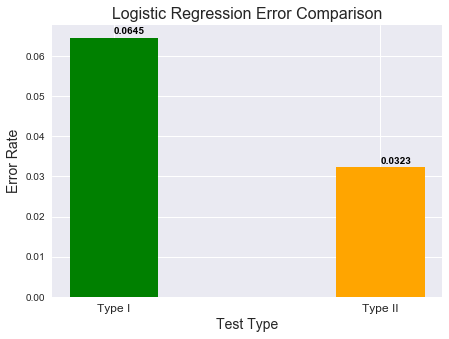

In [440]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_lr, test_tII_lr]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Logistic Regression Error Comparison', fontsize = 16)
plt.savefig('LR')
plt.show()

    [1, 0] - Type II ~ False Negative cases
    [0, 1] - Type I ~ False Positive cases
        Note: in order to reduce these cases in the model, need to tweak the parameters within the model

* Gradient Boost

In [441]:
# we'll make 10 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 10,      
          'max_depth': 2,
          'loss': 'deviance'}

# initialize Gradient Boost model
gbc = ensemble.GradientBoostingClassifier(**params)

# fit the model
gbc.fit(X_train, Y_train)
Y_train_pred = gbc.predict(X_train)
Y_test_pred = gbc.predict(X_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_gbc = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_gbc = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_gbc = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_gbc = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('\nPercentage Accuracy (Training)')
print(gbc.score(X_train, Y_train))

print('\nPercentage Accuracy (Test)')
print(gbc.score(X_test, Y_test))

# cross-validate the gradient boost
print('\nCross Validation')
print(cross_val_score(gbc, X, Y, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_gbc, train_tII_gbc, test_tI_gbc, test_tII_gbc))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_test, Y_test_pred))


Percentage Accuracy (Training)
0.849264705882

Percentage Accuracy (Test)
0.741935483871

Cross Validation
[ 0.90322581  0.70967742  0.74193548  0.80645161  0.86666667  0.73333333
  0.76666667  0.93333333  0.9         0.79310345]


Training set accuracy:
Percent Type I errors: 0.058823529411764705
Percent Type II errors: 0.09191176470588236

Test set accuracy:
Percent Type I errors: 0.16129032258064516
Percent Type II errors: 0.0967741935483871

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    129   16
1.0     25  102

Test Set:

col_0  0.0  1.0
Num            
0.0     14    5
1.0      3    9


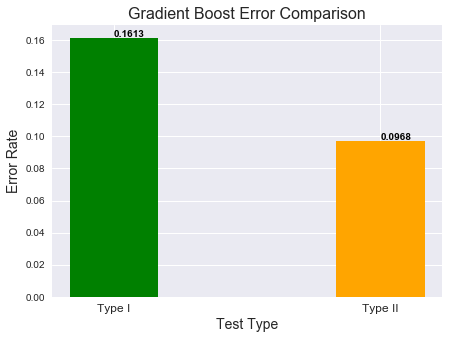

In [442]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_gbc, test_tII_gbc]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Gradient Boost Error Comparison', fontsize = 16)
plt.savefig('GBC')
plt.show()

    Note: seems to be overfiting with high iteration

* Random Forest

In [443]:
# initialize Random Forest model
rfc = ensemble.RandomForestClassifier(max_depth = 5)

# fit the model
rfc.fit(X_train, Y_train)
Y_train_pred = rfc.predict(X_train)
Y_test_pred = rfc.predict(X_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_rfc = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_rfc = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_rfc = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_rfc = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(rfc.score(X_train, Y_train))

print('\nPercentage Accuracy (Test)')
print(rfc.score(X_test, Y_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(rfc, X, Y, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_rfc, train_tII_rfc, test_tI_rfc, test_tII_rfc))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_test, Y_test_pred))


Percentage Accuracy (Training)
0.926470588235

Percentage Accuracy (Test)
0.838709677419

Cross Validation 
[ 0.80645161  0.74193548  0.74193548  0.77419355  0.86666667  0.7
  0.86666667  0.93333333  0.9         0.82758621]


Training set accuracy:
Percent Type I errors: 0.029411764705882353
Percent Type II errors: 0.04411764705882353

Test set accuracy:
Percent Type I errors: 0.12903225806451613
Percent Type II errors: 0.03225806451612903

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    137    8
1.0     12  115

Test Set:

col_0  0.0  1.0
Num            
0.0     15    4
1.0      1   11


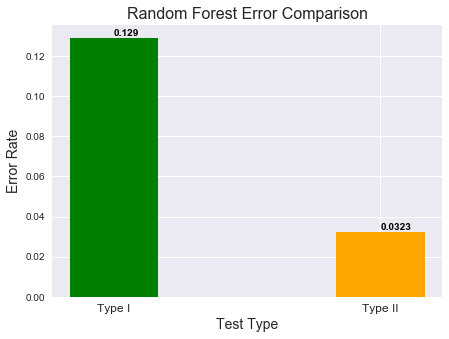

In [444]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_rfc, test_tII_rfc]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Random Forest Error Comparison', fontsize = 16)
plt.savefig('RFC')
plt.show()

* SVM

In [445]:
# initialize SVM for classifers
svc = SVC()

# fit the model
svc.fit(X_train, Y_train)
Y_train_pred = svc.predict(X_train)
Y_test_pred = svc.predict(X_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_svc = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_svc = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_svc = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_svc = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(svc.score(X_train, Y_train))

print('\nPercentage Accuracy (Test)')
print(svc.score(X_test, Y_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(svc, X, Y, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_svc, train_tII_svc, test_tI_svc, test_tII_svc))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_test, Y_test_pred))


Percentage Accuracy (Training)
0.860294117647

Percentage Accuracy (Test)
0.806451612903

Cross Validation 
[ 0.87096774  0.80645161  0.80645161  0.70967742  0.86666667  0.76666667
  0.83333333  0.93333333  0.93333333  0.89655172]


Training set accuracy:
Percent Type I errors: 0.0661764705882353
Percent Type II errors: 0.07352941176470588

Test set accuracy:
Percent Type I errors: 0.16129032258064516
Percent Type II errors: 0.03225806451612903

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    127   18
1.0     20  107

Test Set:

col_0  0.0  1.0
Num            
0.0     14    5
1.0      1   11


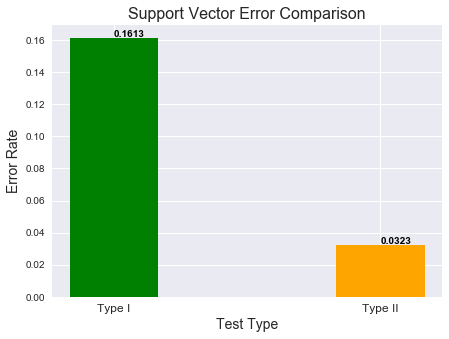

In [446]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_svc, test_tII_svc]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Support Vector Error Comparison', fontsize = 16)
plt.savefig('SVM')
plt.show()

* KNN

In [447]:
# initialize KNN model
knn = KNeighborsClassifier(n_neighbors = 15)

# fit the model
knn.fit(X_train, Y_train)
Y_train_pred = knn.predict(X_train)
Y_test_pred = knn.predict(X_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_knn = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_knn = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_knn = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_knn = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(knn.score(X_train, Y_train))

print('\nPercentage Accuracy (Test)')
print(knn.score(X_test, Y_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(knn, X, Y, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_knn, train_tII_knn, test_tI_knn, test_tII_knn))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_test, Y_test_pred))


Percentage Accuracy (Training)
0.856617647059

Percentage Accuracy (Test)
0.903225806452

Cross Validation 
[ 0.83870968  0.77419355  0.74193548  0.77419355  0.86666667  0.8
  0.83333333  0.93333333  0.83333333  0.89655172]


Training set accuracy:
Percent Type I errors: 0.05514705882352941
Percent Type II errors: 0.08823529411764706

Test set accuracy:
Percent Type I errors: 0.0967741935483871
Percent Type II errors: 0.0

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    130   15
1.0     24  103

Test Set:

col_0  0.0  1.0
Num            
0.0     16    3
1.0      0   12


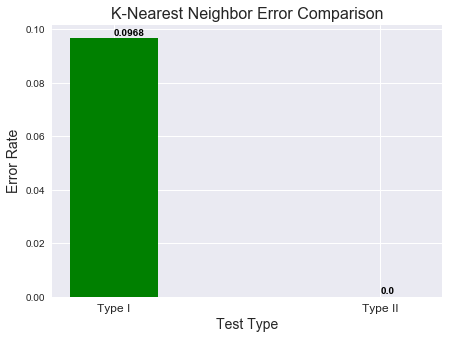

In [448]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_knn, test_tII_knn]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('K-Nearest Neighbor Error Comparison', fontsize = 16)
plt.savefig('KNN')
plt.show()

    Note: 
    the test accuracy is very inconsistent 
    test accuracy higher than training accuracy. Happenes for all classifers except gradient boost

In [449]:
# Create a table to compare the test set results of each classifers
## lr = logistic regression
## gbc = gradient boost classifer
## rfc = random forest classifer
## svc = support vector classifer
## neighbors = k nearest neighbor 
compare_df = pd.DataFrame({'lr':[lr.score(X_test, Y_test)],
                           'gbc':[gbc.score(X_test, Y_test)],
                           'rfc':[rfc.score(X_test, Y_test)],
                           'svc':[svc.score(X_test, Y_test)],
                           'knn':[knn.score(X_test, Y_test)]})

In [450]:
# run 500 different trials of test set
for i in range(500):
    # shuffle the original df
    new_shuf_df = shuffle_data(shuf_df)

    # set targeted variable and features
    Y = new_shuf_df['Num']
    X = new_shuf_df.loc[:, ~new_shuf_df.columns.isin(['Num'])]

    # create a new test set
    new_X_test, new_Y_test = X[trainsize:], Y[trainsize:]
    
    # run the models
    compare_df = compare_df.append({'lr':lr.score(new_X_test, new_Y_test),
                                    'gbc':gbc.score(new_X_test, new_Y_test),
                                    'rfc':rfc.score(new_X_test, new_Y_test),
                                    'svc':svc.score(new_X_test, new_Y_test),
                                    'knn':knn.score(new_X_test, new_Y_test)},
                                  ignore_index = True)
    

compare_df.index.name = 'Tests'

# Try PCA

In [451]:
# make a copy of original data call PCA_df
# shuffle PCA_df
PCA_df = new_df.copy()

# set targeted variable and initialize PCA 
Y_PCA = PCA_df['Num']
X_PCA = PCA_df.loc[:, ~PCA_df.columns.isin(['Num'])]

sklearn_pca = PCA(n_components = 10)      # choosing 13 components because it explains more than 85% of variance
X_PCA = sklearn_pca.fit_transform(X_PCA)
X_PCA = pd.DataFrame(X_PCA)               # transform X_PCA (meta features) into dataframe

# create a training set and test set sizes
trainsize = int(PCA_df.shape[0] * 0.9)
X_PCA_train, Y_PCA_train = X_PCA[:trainsize], Y_PCA[:trainsize]
X_PCA_test, Y_PCA_test = X_PCA[trainsize:], Y_PCA[trainsize:]

In [452]:
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

print(
    '\nThe sum of variances in the dataset explained. \n',
    sum(sklearn_pca.explained_variance_ratio_)
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.23855536  0.13724072  0.10482665  0.08618821  0.08443342  0.05600398
  0.0503804   0.04441006  0.03832058  0.03049553]

The sum of variances in the dataset explained. 
 0.870854927368


In [453]:
X_PCA.shape

(303, 10)

* Logistic Regression w/ PCA meta features

In [454]:
# initialize Logistic Regression model
lr_PCA = LogisticRegression(C = 1e9)

# fit the model.
lr_PCA.fit(X_PCA_train, Y_PCA_train)
Y_train_pred = lr_PCA.predict(X_PCA_train)
Y_test_pred = lr_PCA.predict(X_PCA_test)


# display
print('Coefficients')
print(abs(lr_PCA.coef_))
print(lr_PCA.intercept_)

table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('\nPercentage Accuracy (Training)')
print(lr_PCA.score(X_PCA_train, Y_PCA_train))

print('\nPercentage Accuracy (Test)')
print(lr_PCA.score(X_PCA_test, Y_PCA_test))

# cross-validate the logistic regression
print('\nCross Validation ')
print(cross_val_score(lr_PCA, X_PCA, Y_PCA, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_PCA_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_PCA_test, Y_test_pred))

Coefficients
[[ 2.82730013  0.18332459  0.60553178  0.11059982  0.71967827  0.14772738
   0.29954961  0.49280742  0.30303798  0.62557872]]
[-0.3336022]

Percentage Accuracy (Training)
0.871323529412

Percentage Accuracy (Test)
0.774193548387

Cross Validation 
[ 0.87096774  0.93548387  0.87096774  0.90322581  0.9         0.76666667
  0.86666667  0.83333333  0.76666667  0.79310345]


Training set accuracy:
Percent Type I errors: 0.2647058823529412
Percent Type II errors: 0.29411764705882354

Test set accuracy:
Percent Type I errors: 0.22580645161290322
Percent Type II errors: 0.22580645161290322

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    134   16
1.0     19  103

Test Set:

col_0  0.0  1.0
Num            
0.0     13    1
1.0      6   11


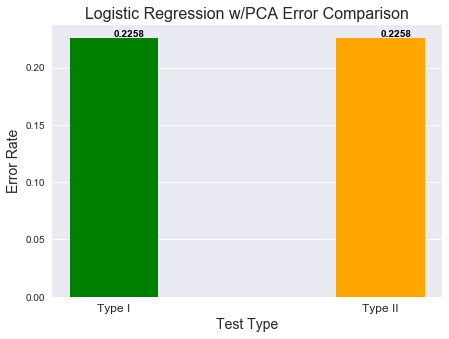

In [455]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_errors, test_tII_errors]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Logistic Regression w/PCA Error Comparison', fontsize = 16)
plt.savefig('PCA_LR')
plt.show()

* Gradient Boost w/ PCA meta features

In [456]:
# we'll make 10 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 10,      
          'max_depth': 2,
          'loss': 'deviance'}

# initialize Gradient Boost model
gbc_PCA = ensemble.GradientBoostingClassifier(**params)

# fit the model
gbc_PCA.fit(X_PCA_train, Y_PCA_train)
Y_train_pred = gbc_PCA.predict(X_PCA_train)
Y_test_pred = gbc_PCA.predict(X_PCA_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('\nPercentage Accuracy (Training)')
print(gbc_PCA.score(X_PCA_train, Y_PCA_train))

print('\nPercentage Accuracy (Test)')
print(gbc_PCA.score(X_PCA_test, Y_PCA_test))

# cross-validate the gradient boost
print('\nCross Validation ')
print(cross_val_score(gbc_PCA, X_PCA, Y_PCA, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_PCA_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_PCA_test, Y_test_pred))


Percentage Accuracy (Training)
0.886029411765

Percentage Accuracy (Test)
0.741935483871

Cross Validation 
[ 0.80645161  0.93548387  0.83870968  0.90322581  0.8         0.83333333
  0.76666667  0.8         0.66666667  0.79310345]


Training set accuracy:
Percent Type I errors: 0.25735294117647056
Percent Type II errors: 0.3014705882352941

Test set accuracy:
Percent Type I errors: 0.22580645161290322
Percent Type II errors: 0.1935483870967742

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    138   12
1.0     19  103

Test Set:

col_0  0.0  1.0
Num            
0.0     12    2
1.0      6   11


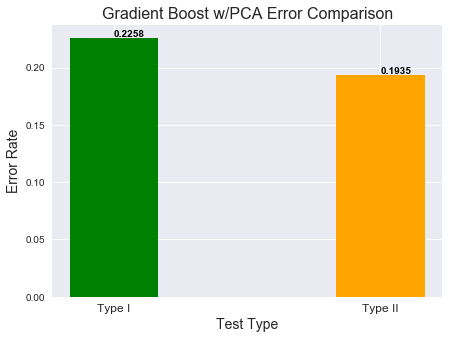

In [457]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_errors, test_tII_errors]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Gradient Boost w/PCA Error Comparison', fontsize = 16)
plt.savefig('PCA_GBC')
plt.show()

    Note: can perform with less iteration in comparison to before PCA

* Random Forest w/ PCA meta features

In [458]:
# initialize Random Forest model
rfc_PCA = ensemble.RandomForestClassifier(max_depth = 15)

# fit the model
rfc_PCA.fit(X_PCA_train, Y_PCA_train)
Y_train_pred = rfc_PCA.predict(X_PCA_train)
Y_test_pred = rfc_PCA.predict(X_PCA_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(rfc_PCA.score(X_PCA_train, Y_PCA_train))

print('\nPercentage Accuracy (Test)')
print(rfc_PCA.score(X_PCA_test, Y_PCA_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(rfc_PCA, X_PCA, Y_PCA, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_PCA_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_PCA_test, Y_test_pred))


Percentage Accuracy (Training)
0.966911764706

Percentage Accuracy (Test)
0.806451612903

Cross Validation 
[ 0.87096774  0.87096774  0.87096774  0.83870968  0.8         0.86666667
  0.76666667  0.86666667  0.7         0.75862069]


Training set accuracy:
Percent Type I errors: 0.25735294117647056
Percent Type II errors: 0.27205882352941174

Test set accuracy:
Percent Type I errors: 0.25806451612903225
Percent Type II errors: 0.22580645161290322

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    145    5
1.0      4  118

Test Set:

col_0  0.0  1.0
Num            
0.0     13    1
1.0      5   12


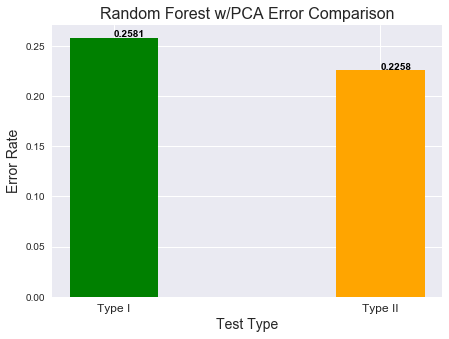

In [459]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_errors, test_tII_errors]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Random Forest w/PCA Error Comparison', fontsize = 16)
plt.savefig('PCA_RFC')
plt.show()

* SVM w/ PCA meta features

In [460]:
# initialize SVM for classifers
svc_PCA = SVC()

# fit the model
svc_PCA.fit(X_PCA_train, Y_PCA_train)
Y_train_pred = svc_PCA.predict(X_PCA_train)
Y_test_pred = svc_PCA.predict(X_PCA_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(svc_PCA.score(X_PCA_train, Y_PCA_train))

print('\nPercentage Accuracy (Test)')
print(svc_PCA.score(X_PCA_test, Y_PCA_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(svc_PCA, X_PCA, Y_PCA, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_PCA_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_PCA_test, Y_test_pred))


Percentage Accuracy (Training)
0.878676470588

Percentage Accuracy (Test)
0.806451612903

Cross Validation 
[ 0.87096774  0.90322581  0.93548387  0.93548387  0.8         0.76666667
  0.83333333  0.83333333  0.76666667  0.82758621]


Training set accuracy:
Percent Type I errors: 0.26838235294117646
Percent Type II errors: 0.2977941176470588

Test set accuracy:
Percent Type I errors: 0.2903225806451613
Percent Type II errors: 0.1935483870967742

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    135   15
1.0     18  104

Test Set:

col_0  0.0  1.0
Num            
0.0     12    2
1.0      4   13


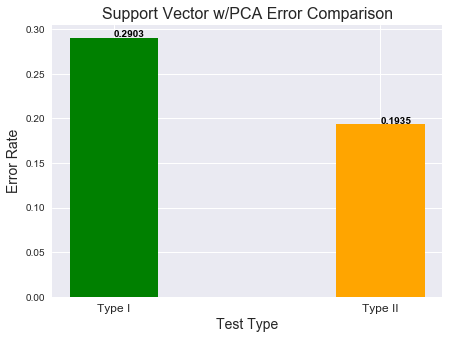

In [461]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_errors, test_tII_errors]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('Support Vector w/PCA Error Comparison', fontsize = 16)
plt.savefig('PCA_SVM')
plt.show()

* KNN w/ PCA meta features

In [462]:
# initialize KNN model
knn_PCA = KNeighborsClassifier(n_neighbors = 15)

# fit the model
knn_PCA.fit(X_PCA_train, Y_PCA_train)
Y_train_pred = knn_PCA.predict(X_PCA_train)
Y_test_pred = knn_PCA.predict(X_PCA_test)

# display accuracy tables
table_train = pd.crosstab(Y_train, Y_train_pred, margins=True)
table_test = pd.crosstab(Y_test, Y_test_pred, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

# display
print('\nPercentage Accuracy (Training)')
print(knn_PCA.score(X_PCA_train, Y_PCA_train))

print('\nPercentage Accuracy (Test)')
print(knn_PCA.score(X_PCA_test, Y_PCA_test))

# cross-validate the random forest
print('\nCross Validation ')
print(cross_val_score(knn_PCA, X_PCA, Y_PCA, cv = 10))
print('\n')

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

print('\nAccuracy of Heart Diease Diagnostics')
print('Training Set:\n')
print(pd.crosstab(Y_PCA_train, Y_train_pred))
print('\nTest Set:\n')
print(pd.crosstab(Y_PCA_test, Y_test_pred))


Percentage Accuracy (Training)
0.871323529412

Percentage Accuracy (Test)
0.838709677419

Cross Validation 
[ 0.87096774  0.83870968  0.87096774  0.93548387  0.86666667  0.86666667
  0.86666667  0.8         0.76666667  0.89655172]


Training set accuracy:
Percent Type I errors: 0.2610294117647059
Percent Type II errors: 0.28308823529411764

Test set accuracy:
Percent Type I errors: 0.2903225806451613
Percent Type II errors: 0.16129032258064516

Accuracy of Heart Diease Diagnostics
Training Set:

col_0  0.0  1.0
Num            
0.0    133   17
1.0     18  104

Test Set:

col_0  0.0  1.0
Num            
0.0     12    2
1.0      3   14


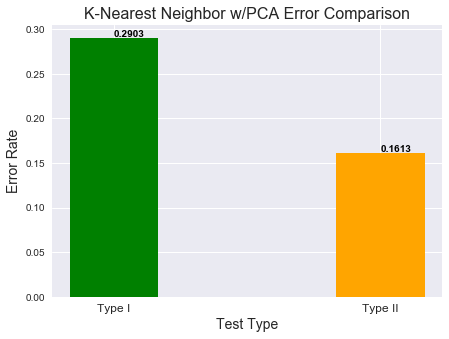

In [463]:
# plot bar graph for Test Set accuracy
y_val = [test_tI_errors, test_tII_errors]   
x_pos = np.arange(len(obj))         
wid = np.min(np.diff(x_pos))/3      
plt.figure(figsize = (7,5))

ax = plt.subplot()
T1 = ax.bar(x_pos[0], y_val[0], wid, color = 'green', label = 'Type I')
T2 = ax.bar(x_pos[1], y_val[1], wid, color = 'orange', label = 'Type II')

for i, v in enumerate(y_val, ):
    ax.text(i/1, v+0.001, round(v, 4), color = 'black', fontweight = 'bold')
    
ax.set_xticks(x_pos)
ax.set_xticklabels(['Type I', 'Type II'], fontsize = 12)
ax.set_ylabel('Error Rate', fontsize = 14)
ax.set_xlabel('Test Type', fontsize = 14)
ax.set_title('K-Nearest Neighbor w/PCA Error Comparison', fontsize = 16)
plt.savefig('PCA_KNN')
plt.show()

In [464]:
# Create a table to compare the test set results of each classifers

compare_PCA_df = pd.DataFrame({'lr_PCA':[lr_PCA.score(X_PCA_test, Y_PCA_test)],
                               'gbc_PCA':[gbc_PCA.score(X_PCA_test, Y_PCA_test)],
                               'rfc_PCA':[rfc_PCA.score(X_PCA_test, Y_PCA_test)],
                               'svc_PCA':[svc_PCA.score(X_PCA_test, Y_PCA_test)],
                               'knn_PCA':[knn_PCA.score(X_PCA_test, Y_PCA_test)]})
compare_PCA_df.index.name = 'Tests'

In [465]:
print(compare_PCA_df)
print('\n')
print(compare_df.head())
print('\nSummary Statistics of each Classifers:\n')
print(compare_df.describe())

        gbc_PCA  knn_PCA    lr_PCA   rfc_PCA   svc_PCA
Tests                                                 
0      0.741935  0.83871  0.774194  0.806452  0.806452


            gbc       knn        lr       rfc       svc
Tests                                                  
0      0.741935  0.903226  0.903226  0.838710  0.806452
1      0.774194  0.774194  0.870968  0.870968  0.806452
2      0.903226  0.838710  0.903226  0.903226  0.806452
3      0.870968  0.870968  0.903226  0.967742  0.870968
4      0.838710  0.870968  0.935484  0.935484  0.838710

Summary Statistics of each Classifers:

              gbc         knn          lr         rfc         svc
count  501.000000  501.000000  501.000000  501.000000  501.000000
mean     0.836134    0.857189    0.868521    0.915137    0.850557
std      0.064883    0.058254    0.056780    0.045863    0.060357
min      0.580645    0.677419    0.677419    0.774194    0.645161
25%      0.806452    0.806452    0.838710    0.903226    0.806452
50% 

In [466]:
compare_PCA_df

,gbc_PCA,knn_PCA,lr_PCA,rfc_PCA,svc_PCA
Tests,,,,,
0,0.741935,0.83871,0.774194,0.806452,0.806452


    The meta features generated from PCA did not improve the accuracy rates, so I want to stick with the original method.

In [467]:
# create a temp list of classifers
temp = list(compare_df.columns)

# Run T-test for all the classifers
for x in compare_df.columns:
    for y in temp:
        if x!=y:
            t_stat, p_val = scipy.stats.ttest_ind(compare_df[x], compare_df[y])
            print('T-test between {} and {}'.format(x,y))
            print('T-Value: {}'.format(round(t_stat, 6)))
            print('P-Value: {}'.format( p_val))
            print('\n')
    #temp.remove(temp[0])
    print('**********************************************************')
        

T-test between gbc and knn
T-Value: -5.404624
P-Value: 8.120493522594145e-08


T-test between gbc and lr
T-Value: -8.407812
P-Value: 1.4253219710534782e-16


T-test between gbc and rfc
T-Value: -22.255595
P-Value: 1.8838739162351892e-89


T-test between gbc and svc
T-Value: -3.642986
P-Value: 0.00028333448458418966


**********************************************************
T-test between knn and gbc
T-Value: 5.404624
P-Value: 8.120493522594145e-08


T-test between knn and lr
T-Value: -3.118065
P-Value: 0.0018724644283922944


T-test between knn and rfc
T-Value: -17.494504
P-Value: 5.424108954687329e-60


T-test between knn and svc
T-Value: 1.769619
P-Value: 0.0770952672644382


**********************************************************
T-test between lr and gbc
T-Value: 8.407812
P-Value: 1.4253219710534782e-16


T-test between lr and knn
T-Value: 3.118065
P-Value: 0.0018724644283922944


T-test between lr and rfc
T-Value: -14.295565
P-Value: 2.5478870625875607e-42


T-test between lr

# Conclusion    
    From the result, the Random Forest Classifier is the most accurate for this dataset. From summary statistic, it has the highest accuracy rate and least variance. And from the T-tests, RFC generally has smaller p-values and the t-values are also appearing to be more statistically significant in comparision to other classifiers.